In [71]:
#@title
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

In [44]:
import tensorflow as tf
from sklearn.model_selection import KFold

from keras.models import Sequential # most of the time we design a "sequence" of layers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
#from __future__ import print_function
import numpy as np
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator # to create realistic geometrical deformations of the images
from tensorflow.keras.utils import to_categorical # this does the same as OneHotEncoder
# we import a lot of network design specific functions that we may need
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU, ReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import os
from tensorflow.python.framework import ops
from sklearn.preprocessing import OneHotEncoder

In [3]:
import glob
import cv2

In [4]:
from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# Background information for the project:

Our company(Monreader) develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

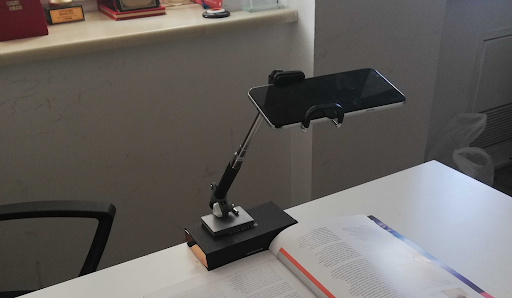


###Data Description:

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

In [7]:

# Establish the path to read all of the images 

path_training_flip = glob.glob('drive/MyDrive/Colab Notebooks/apziva/images/training/flip/*.jpg')

path_training_notflip = glob.glob('drive/MyDrive/Colab Notebooks/apziva/images/training/notflip/*.jpg')

path_testing_flip = glob.glob('drive/MyDrive/Colab Notebooks/apziva/images/testing/flip/*.jpg')

path_testing_notflip = glob.glob('drive/MyDrive/Colab Notebooks/apziva/images/testing/notflip/*.jpg')

In [8]:
# Define a function that will do all the preprocessing for each image to be ready for modeling

def image_preprocessing(path):
    # Create an empty list to store all the preprocessed images
    images = []
    # Start by creating a for loop through all the path and make the preprocessing to each image
    for i in path:
        # Firstly read the image
        img = cv2.imread(i)
        # Adjust the size so all iamges will have the same size
        #img =tf.image.resize(image,(128,128),method='gaussian',antialias=True)   

        
        img = cv2.resize(img, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
        
        # Crop to remove part of the images I don't need for the modeling part
        y,h,x,w = 0,100,0,70
        img = img[y:y+h, x:x+w]
        # Adjust brightness, contrast
        alpha=1.5
        beta=0.5
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        # Normalize the images to be black and white by reverting the images and then dividing by 255.0
        img = cv2.bitwise_not(img)
        img = img/255

        # Append the img to the list images
        images.append(img)
        # Create the video

    # Return the list with the preprocessed images
    return images

In [9]:
# def process_images(image,label):
#     #image=tf.image.per_image_standardization(image)
#     image=tf.image.resize(image,(128,128),method='gaussian',antialias=True)   
#     return image,label

# here extract the images with pre-processing 

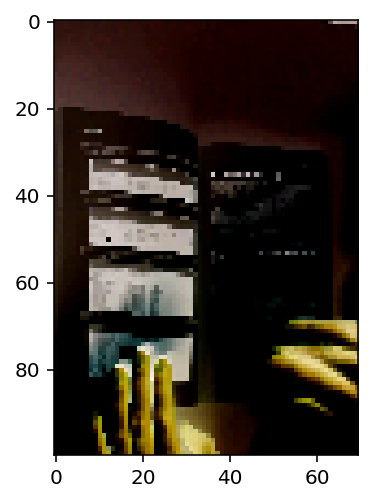

In [10]:
test_flip = image_preprocessing(path_testing_flip)
test_notflip = image_preprocessing(path_testing_notflip)
train_flip = image_preprocessing(path_training_flip)
train_notflip = image_preprocessing(path_training_notflip)

plt.imshow(test_flip[0])
plt.imshow(test_notflip[0])
plt.imshow(train_flip[0])
plt.imshow(train_notflip[0])

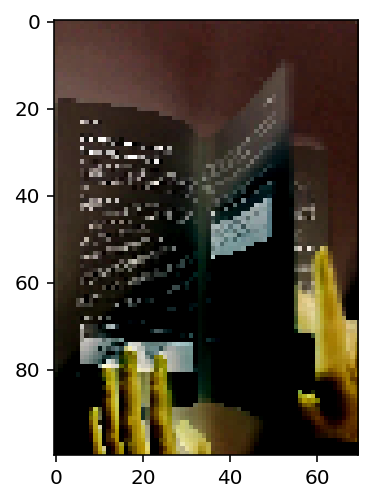

In [14]:
plt.imshow(train_flip[0])

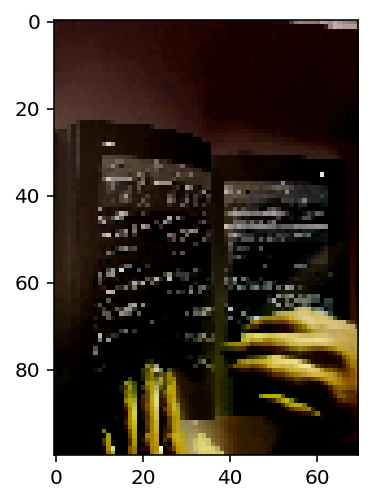

In [15]:
plt.imshow(test_notflip[0])

In [21]:
type(test_flip[0])

numpy.ndarray

# assigning labels (y) for training and testing data:
0 -- not flip

1 -- flip

In [23]:
test_flip_label = np.repeat(1,len(test_flip))
test_notflip_label = np.repeat(0,len(test_notflip))
train_flip_lebel = np.repeat(1,len(train_flip))
train_notflip_lebel = np.repeat(0,len(train_notflip))

597
597
1


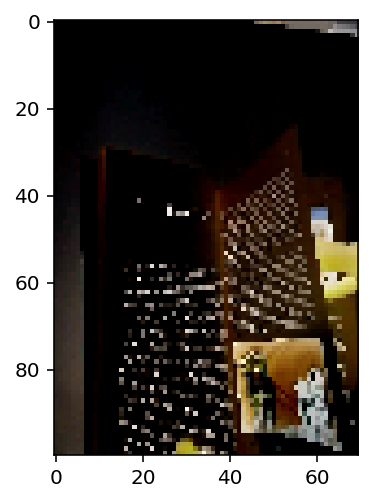

In [66]:
trainX = train_flip + train_notflip    # here we combine the both classes of training data (X input)
trainY = np.concatenate((train_flip_lebel,train_notflip_lebel))  # combine the training labels (Y output)

testX = test_flip + test_notflip  # here we combine the both classes of testing data (X input)
testY = np.concatenate((test_flip_label,test_notflip_label))   # combine the testing labels (Y output)
print(len(testX))
print(len(testY))
plt.imshow(testX[100])
print(testY[100])

## here needs to transform the input from list to array

In [67]:
#trainY = to_categorical(trainY)
#testY = to_categorical(testY)


trainX = np.array(trainX)
testX = np.array(testX)
type(trainX)

numpy.ndarray

In [12]:
type(test_flip)

list

# Here we define the covolutional neural network (this one has 4 filter layers,2 dense layers)

In [72]:
def define_model():
    # this is the actual design of the CNN - here the input_shape needs to acocmodate the upscaled resolution, e.g. (128,128,3)
    model = Sequential()
    # the convolutions
    model.add(Conv2D(filters=32,kernel_size=(11, 11),activation = 'relu', kernel_initializer='he_uniform',padding='same',input_shape=(100,70,3)))  # first kernel, (100,70,3) size fits the size of the image
    model.add(BatchNormalization())  # normalizes the distortions
    model.add(MaxPooling2D(pool_size=(2,2)))   # pools the information
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))   #second kernel
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    # here we stopped making convolutions
    model.add(Flatten())


    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.2))
    # the output layer must equate the number of classes
    model.add(Dense(1,activation='sigmoid'))

    # initiate optimizer
    opt = Adam(learning_rate=0.01)

    # Let's train the model using the chosen optimizer
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
    return model

In [73]:
# def neural_network():
#     model = Sequential()
#     model.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform', 
#                      padding = 'same', input_shape=(100, 70, 3)))
#     model.add(MaxPooling2D((2, 2)))
    
#     model.add(Flatten())
    
#     model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
#     model.add(Dense(1, activation='sigmoid'))
#     # compile model
#     opt = SGD(lr=0.001, momentum=0.9)
#     model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#     return model


# the following functions does cross validation on thje model, summarize the diagnostics and plots a graph

In [74]:
def evaluate_model(dataX, dataY, n_folds=5):  
	scores, histories = list(), list()
	# prepare cross validation
    
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=25, batch_size=128, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Binary Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
		plt.tight_layout(pad=3.0)
	plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()
 

In [75]:
def run_everything():
	vals= []
	# load dataset
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	vals.append(scores)
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
	print('The overall accuracy is :'+str(np.mean(vals)))
 

> 96.868
> 98.121
> 99.791
> 96.444
> 89.958


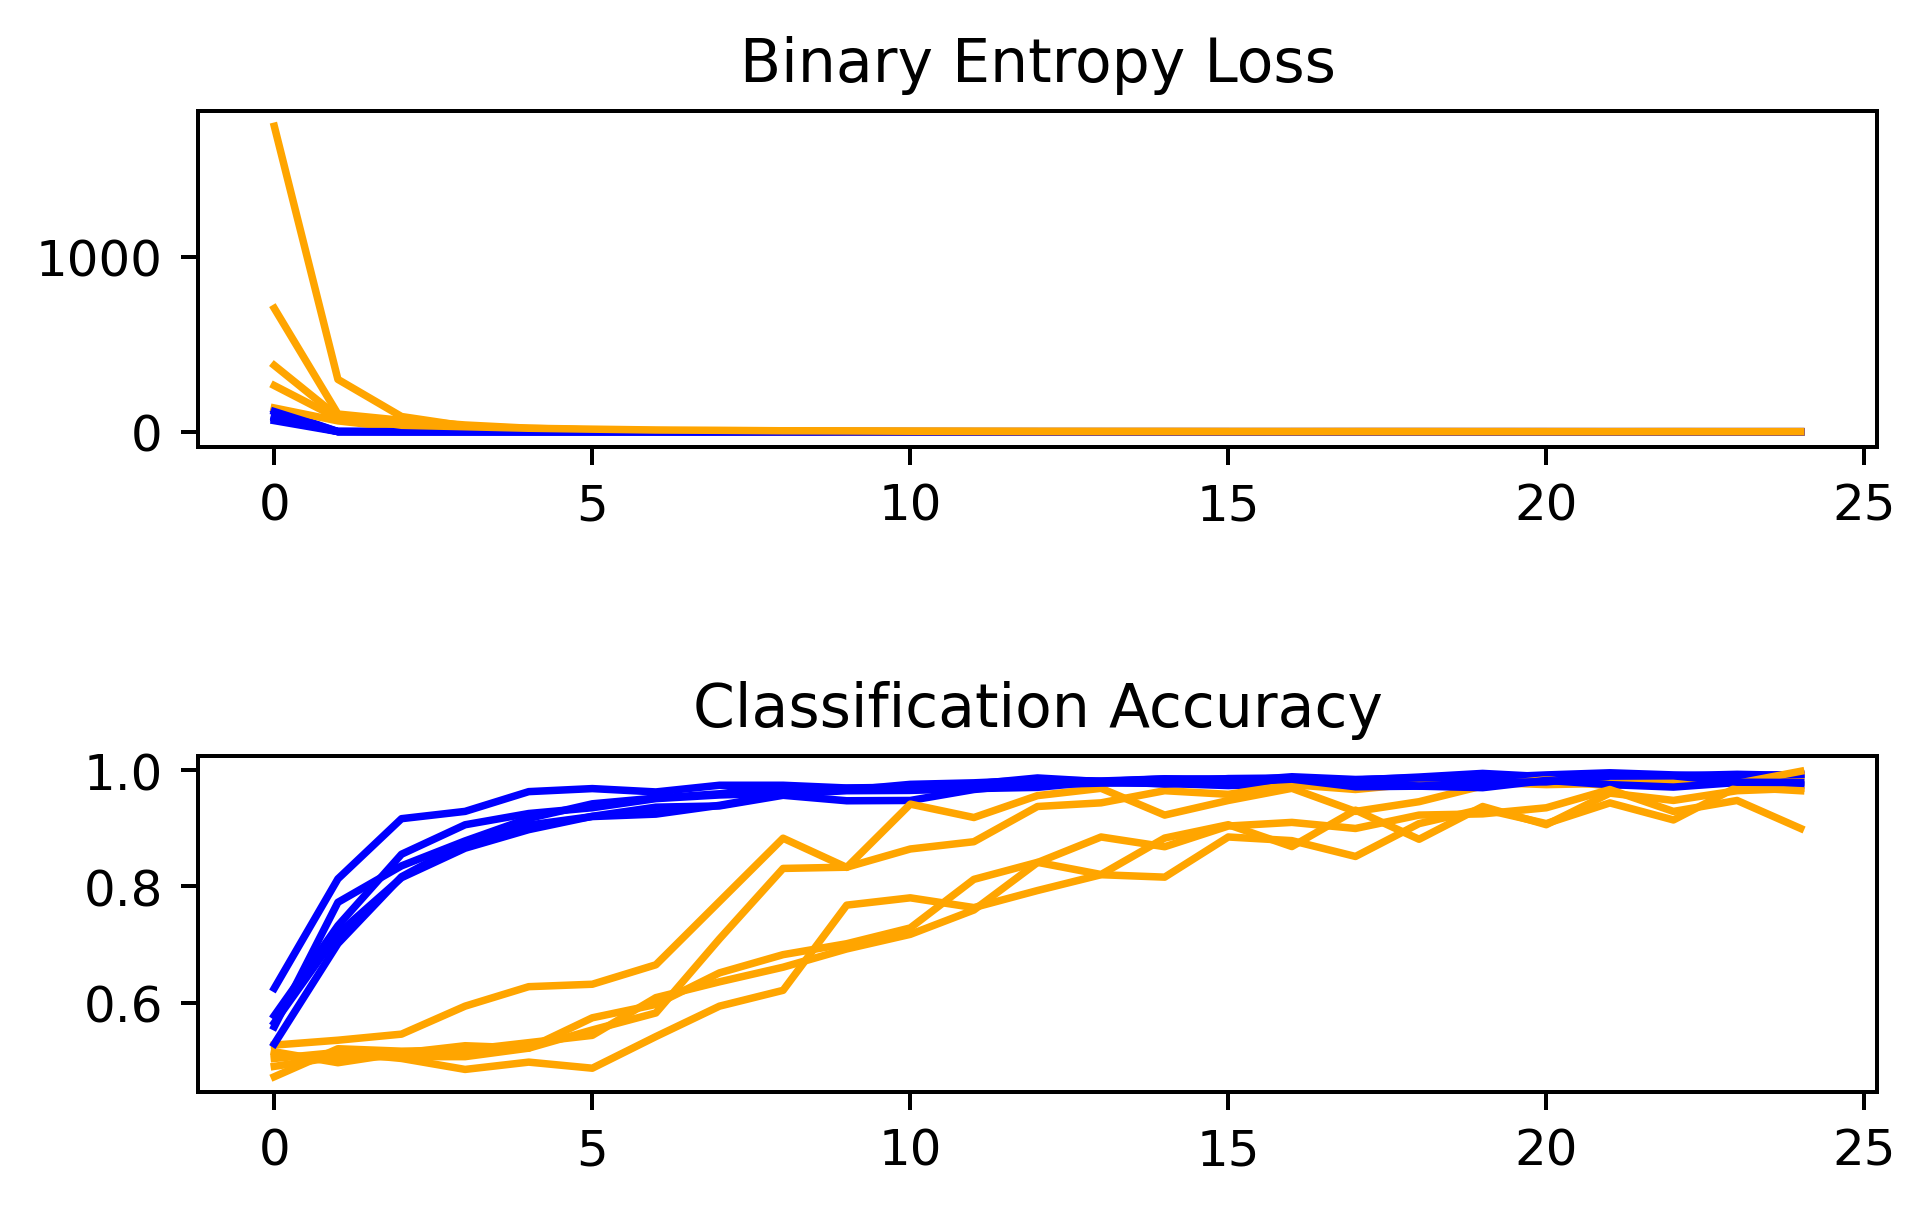

Accuracy: mean=96.236 std=3.348, n=5


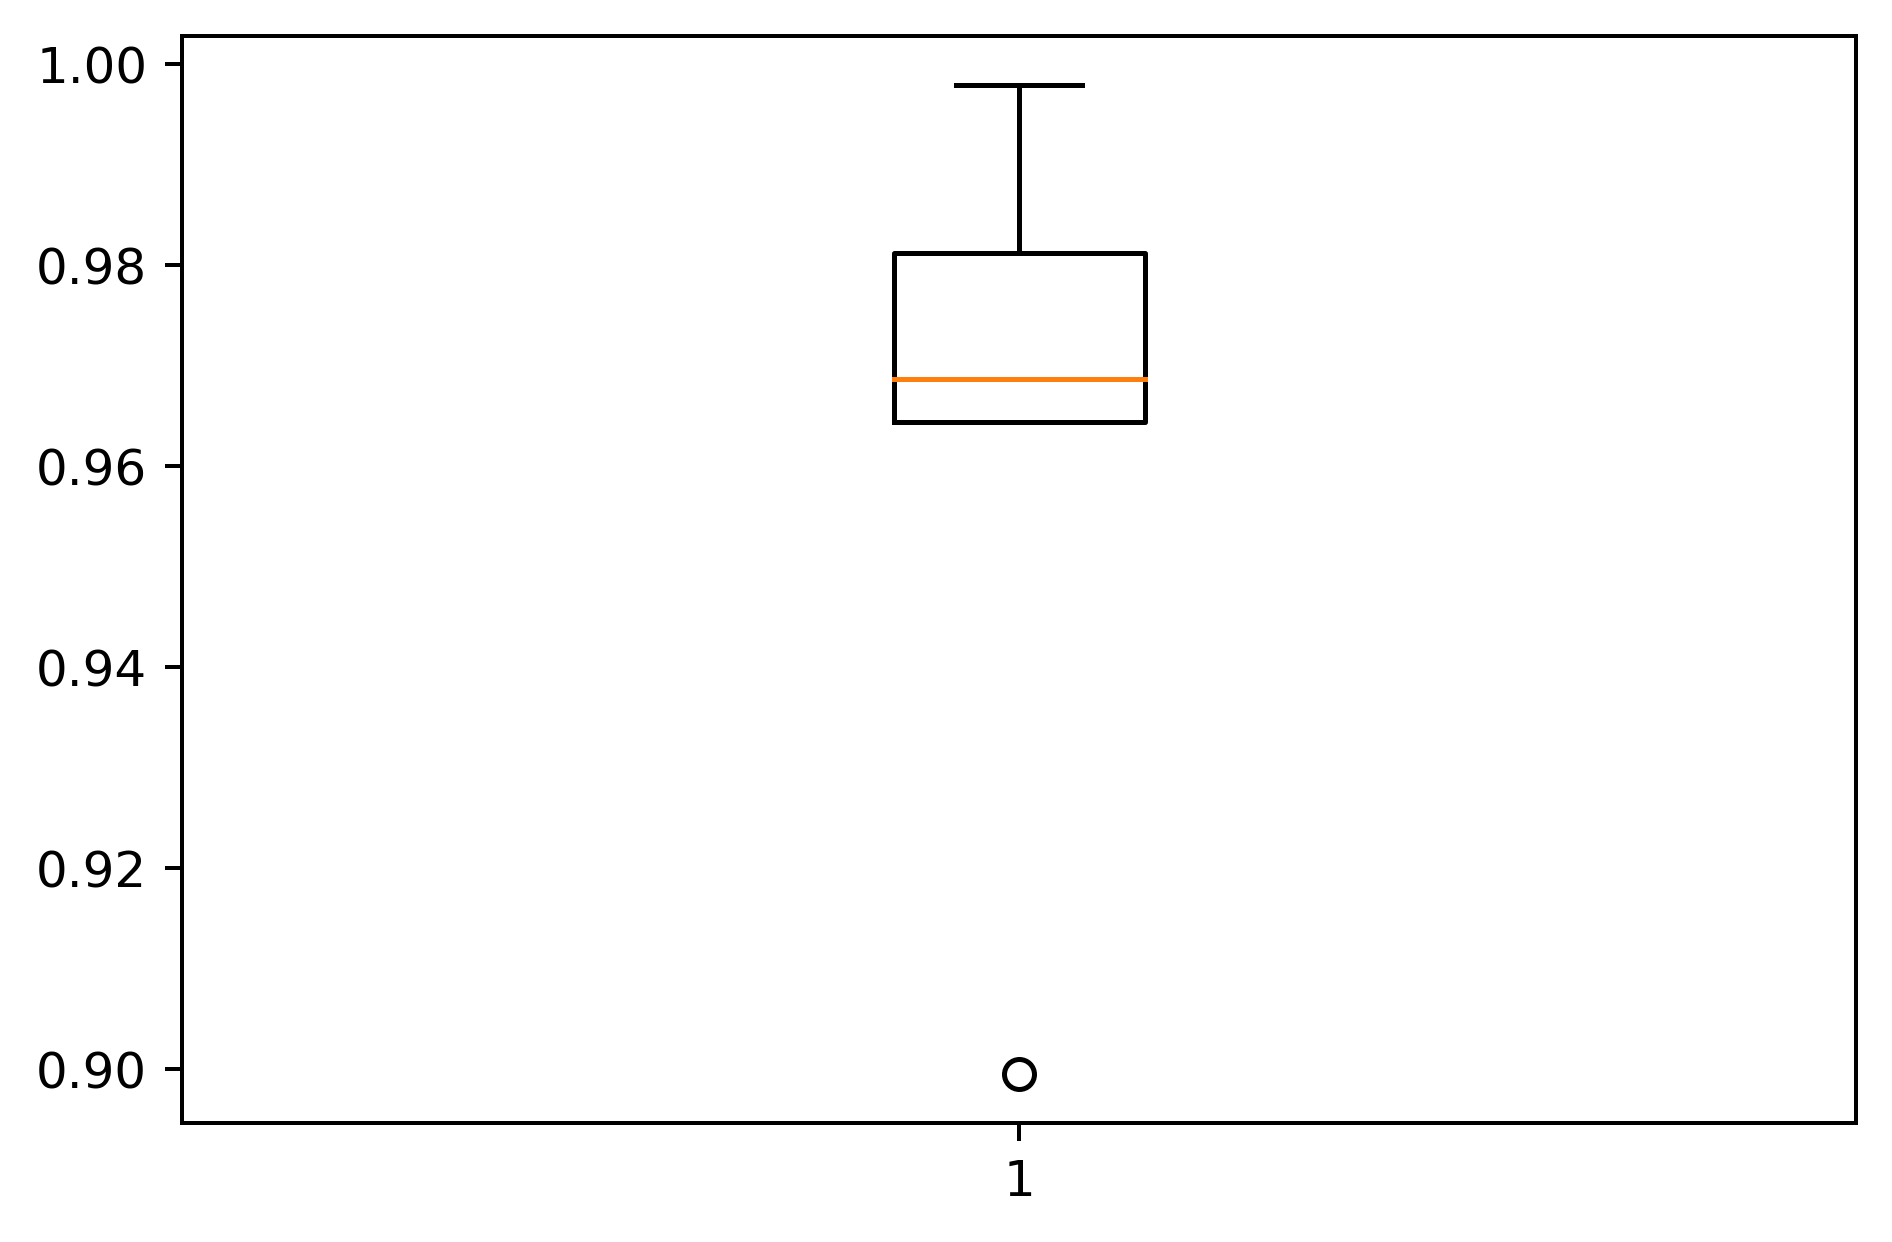

The overall accuracy is :0.9623640537261963


In [77]:
run_everything()

In [81]:
model = define_model()

model.fit(trainX, trainY, epochs=25, batch_size=128, verbose=0)

In [83]:
_, acc = model.evaluate(testX, testY, verbose=0)
acc

0.9832496047019958

In [87]:
y_pred_test = model.predict(testX)
y_pred_test =(y_pred_test>0.5)
type(y_pred_test)


numpy.ndarray

In [89]:
from sklearn.metrics import classification_report

print(classification_report(testY,y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       307
           1       0.99      0.98      0.98       290

    accuracy                           0.98       597
   macro avg       0.98      0.98      0.98       597
weighted avg       0.98      0.98      0.98       597



In [ ]:
# VERY decent accuracy and F score on the testing data